In [19]:
%matplotlib inline

### Install Python Packages

In [20]:
# include our Python packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.autograd import Function
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm

### Get MNIST Dataset and DataLoader

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Flatten operation (assuming you want to flatten the tensor along the spatial dimensions)
flatten = transforms.Lambda(lambda x: x.view(-1))

# Combine the original transforms with the flatten operation
combined_transform = transforms.Compose([
    transform,
    flatten,
])

train_dataset = MNIST(root='./data', train=True, transform=combined_transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)

test_dataset = MNIST(root='./data', train=False, download=True, transform=combined_transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=True)

#### View Images

In [22]:
# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples)

# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

### Create MLP

In [23]:
class MLP(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(D_in, H1),
            nn.ReLU(),
            nn.Linear(H1, H2),
            nn.ReLU(),
            nn.Linear(H2, D_out),
        )
    def forward(self, x):
        y_pred = self.layers(x)
        return y_pred

### Create Convolutional Nerual Net

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Select Model and Define HyperParameters

In [25]:
model = MLP(
    D_in = 28*28,
    H1 = 28*28,
    H2 = 128,
    D_out = 10,
)
# model = CNN()

print(model)

epochs = 50
learning_rate = 0.001
momentum = 0.3

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

criterion = nn.CrossEntropyLoss()

status_interval = 10

MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): ReLU()
    (2): Linear(in_features=784, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Define Training Function

In [26]:
train_loss = []
train_count = []
test_loss = []
test_count = [i*len(train_loader.dataset) for i in range(epochs + 1)]

def train(epoch, dataloader, optimizer):
    model.train()

    print(f'Train Epoch: {epoch}')

    for batch, (data, label) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, label)
        # loss = F.nll_loss(output, label)
        loss.backward()

        optimizer.step()

        if batch % status_interval == 0:
            # print(f'Train Epoch: {epoch} [{batch * len(data)}/{len(dataloader.dataset)}] ({batch * 100 / len(dataloader):.0f}%)\tLoss: {loss.item():.6f}')
            train_loss.append(loss.item())
            train_count.append((batch*64) + ((epoch-1)*len(dataloader.dataset)))

    print(f'Loss: {loss.item():.6f}')

### Define Training Function

In [27]:
def test(dataloader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, label in dataloader:
            output = model(data)
            loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(label.data.view_as(pred)).sum()
    loss /= len(dataloader.dataset)
    test_loss.append(loss)
    print(f'\nTest Set: Avg. Loss: {loss:.4f}, Accuracy: {correct}/{len(dataloader.dataset)} ({100 * correct / len(dataloader.dataset):.0f}%)')

### Train Model

In [28]:
# test(dataloader=test_loader)
for epoch in range(0, epochs):
     print('==='*30)
     train(epoch=epoch+1, dataloader=train_loader, optimizer=optimizer)
     test(dataloader=test_loader)

Train Epoch: 1


1200it [00:27, 42.93it/s]


Loss: 1.637042

Test Set: Avg. Loss: -0.9410, Accuracy: 7193/10000 (72%)
Train Epoch: 2


1200it [00:29, 40.01it/s]


Loss: 0.889754

Test Set: Avg. Loss: -3.0546, Accuracy: 8406/10000 (84%)
Train Epoch: 3


1200it [00:28, 41.50it/s]


Loss: 0.618539

Test Set: Avg. Loss: -4.6033, Accuracy: 8682/10000 (87%)
Train Epoch: 4


1200it [00:28, 41.83it/s]


Loss: 0.564092

Test Set: Avg. Loss: -5.5721, Accuracy: 8807/10000 (88%)
Train Epoch: 5


1200it [00:26, 45.18it/s]


Loss: 0.411550

Test Set: Avg. Loss: -6.2070, Accuracy: 8902/10000 (89%)
Train Epoch: 6


1200it [00:27, 43.63it/s]


Loss: 0.485127

Test Set: Avg. Loss: -6.6615, Accuracy: 8961/10000 (90%)
Train Epoch: 7


1200it [00:27, 43.64it/s]


Loss: 0.503585

Test Set: Avg. Loss: -6.9796, Accuracy: 9007/10000 (90%)
Train Epoch: 8


1200it [00:30, 39.68it/s]


Loss: 0.250900

Test Set: Avg. Loss: -7.2247, Accuracy: 9046/10000 (90%)
Train Epoch: 9


1200it [00:28, 42.31it/s]


Loss: 0.458668

Test Set: Avg. Loss: -7.4222, Accuracy: 9057/10000 (91%)
Train Epoch: 10


1200it [00:31, 37.90it/s]


Loss: 0.254496

Test Set: Avg. Loss: -7.5854, Accuracy: 9109/10000 (91%)
Train Epoch: 11


1200it [00:26, 44.84it/s]


Loss: 0.290133

Test Set: Avg. Loss: -7.7240, Accuracy: 9130/10000 (91%)
Train Epoch: 12


1200it [00:31, 38.57it/s]


Loss: 0.452144

Test Set: Avg. Loss: -7.8497, Accuracy: 9140/10000 (91%)
Train Epoch: 13


1200it [00:28, 42.79it/s]


Loss: 0.253115

Test Set: Avg. Loss: -7.9421, Accuracy: 9165/10000 (92%)
Train Epoch: 14


1200it [00:31, 37.85it/s]


Loss: 0.167103

Test Set: Avg. Loss: -8.0389, Accuracy: 9174/10000 (92%)
Train Epoch: 15


1200it [00:31, 38.53it/s]


Loss: 0.168867

Test Set: Avg. Loss: -8.1138, Accuracy: 9204/10000 (92%)
Train Epoch: 16


1200it [00:27, 44.35it/s]


Loss: 0.281980

Test Set: Avg. Loss: -8.1862, Accuracy: 9200/10000 (92%)
Train Epoch: 17


1200it [00:32, 36.64it/s]


Loss: 0.443564

Test Set: Avg. Loss: -8.2420, Accuracy: 9242/10000 (92%)
Train Epoch: 18


1200it [00:33, 36.27it/s]


Loss: 0.207979

Test Set: Avg. Loss: -8.2994, Accuracy: 9263/10000 (93%)
Train Epoch: 19


1200it [00:36, 32.43it/s]


Loss: 0.274123

Test Set: Avg. Loss: -8.3516, Accuracy: 9264/10000 (93%)
Train Epoch: 20


1200it [00:27, 44.34it/s]


Loss: 0.281359

Test Set: Avg. Loss: -8.3986, Accuracy: 9277/10000 (93%)
Train Epoch: 21


1200it [00:30, 39.46it/s]


Loss: 0.582513

Test Set: Avg. Loss: -8.4426, Accuracy: 9281/10000 (93%)
Train Epoch: 22


1200it [00:30, 38.94it/s]


Loss: 0.212150

Test Set: Avg. Loss: -8.4830, Accuracy: 9297/10000 (93%)
Train Epoch: 23


1200it [00:28, 41.59it/s]


Loss: 0.264565

Test Set: Avg. Loss: -8.5385, Accuracy: 9305/10000 (93%)
Train Epoch: 24


1200it [00:25, 47.53it/s]


Loss: 0.251724

Test Set: Avg. Loss: -8.5494, Accuracy: 9313/10000 (93%)
Train Epoch: 25


1200it [00:29, 41.03it/s]


Loss: 0.123962

Test Set: Avg. Loss: -8.5816, Accuracy: 9320/10000 (93%)
Train Epoch: 26


1200it [00:31, 38.00it/s]


Loss: 0.083284

Test Set: Avg. Loss: -8.6098, Accuracy: 9338/10000 (93%)
Train Epoch: 27


1200it [00:25, 46.26it/s]


Loss: 0.187092

Test Set: Avg. Loss: -8.6474, Accuracy: 9355/10000 (94%)
Train Epoch: 28


1200it [00:34, 34.40it/s]


Loss: 0.151692

Test Set: Avg. Loss: -8.6700, Accuracy: 9341/10000 (93%)
Train Epoch: 29


1200it [00:27, 43.40it/s]


Loss: 0.322017

Test Set: Avg. Loss: -8.7222, Accuracy: 9368/10000 (94%)
Train Epoch: 30


1200it [00:25, 46.35it/s]


Loss: 0.337718

Test Set: Avg. Loss: -8.7455, Accuracy: 9374/10000 (94%)
Train Epoch: 31


1200it [00:29, 40.33it/s]


Loss: 0.138480

Test Set: Avg. Loss: -8.7798, Accuracy: 9375/10000 (94%)
Train Epoch: 32


1200it [00:29, 40.16it/s]


Loss: 0.303674

Test Set: Avg. Loss: -8.8102, Accuracy: 9398/10000 (94%)
Train Epoch: 33


1200it [00:30, 39.77it/s]


Loss: 0.124531

Test Set: Avg. Loss: -8.8562, Accuracy: 9401/10000 (94%)
Train Epoch: 34


1200it [00:31, 38.34it/s]


Loss: 0.359565

Test Set: Avg. Loss: -8.8879, Accuracy: 9412/10000 (94%)
Train Epoch: 35


1200it [00:31, 37.70it/s]


Loss: 0.478677

Test Set: Avg. Loss: -8.9106, Accuracy: 9410/10000 (94%)
Train Epoch: 36


1200it [00:30, 39.83it/s]


Loss: 0.139222

Test Set: Avg. Loss: -8.9366, Accuracy: 9429/10000 (94%)
Train Epoch: 37


1200it [00:29, 40.03it/s]


Loss: 0.224327

Test Set: Avg. Loss: -8.9912, Accuracy: 9426/10000 (94%)
Train Epoch: 38


1200it [00:34, 35.24it/s]


Loss: 0.253652

Test Set: Avg. Loss: -9.0085, Accuracy: 9447/10000 (94%)
Train Epoch: 39


1200it [00:27, 44.40it/s]


Loss: 0.307081

Test Set: Avg. Loss: -9.0277, Accuracy: 9446/10000 (94%)
Train Epoch: 40


1200it [00:26, 45.38it/s]


Loss: 0.066465

Test Set: Avg. Loss: -9.0513, Accuracy: 9450/10000 (94%)
Train Epoch: 41


1200it [00:30, 39.93it/s]


Loss: 0.320313

Test Set: Avg. Loss: -9.0663, Accuracy: 9461/10000 (95%)
Train Epoch: 42


1200it [00:30, 38.85it/s]


Loss: 0.153383

Test Set: Avg. Loss: -9.1154, Accuracy: 9470/10000 (95%)
Train Epoch: 43


1200it [00:27, 42.97it/s]


Loss: 0.328141

Test Set: Avg. Loss: -9.1444, Accuracy: 9471/10000 (95%)
Train Epoch: 44


1200it [00:25, 46.75it/s]


Loss: 0.166355

Test Set: Avg. Loss: -9.1553, Accuracy: 9495/10000 (95%)
Train Epoch: 45


1200it [00:28, 42.46it/s]


Loss: 0.196376

Test Set: Avg. Loss: -9.1774, Accuracy: 9492/10000 (95%)
Train Epoch: 46


1200it [00:27, 43.82it/s]


Loss: 0.154420

Test Set: Avg. Loss: -9.2265, Accuracy: 9498/10000 (95%)
Train Epoch: 47


1200it [00:29, 40.61it/s]


Loss: 0.062590

Test Set: Avg. Loss: -9.2214, Accuracy: 9491/10000 (95%)
Train Epoch: 48


1200it [00:27, 44.25it/s]


Loss: 0.108036

Test Set: Avg. Loss: -9.2612, Accuracy: 9502/10000 (95%)
Train Epoch: 49


1200it [00:30, 38.88it/s]


Loss: 0.285620

Test Set: Avg. Loss: -9.2724, Accuracy: 9503/10000 (95%)
Train Epoch: 50


1200it [00:29, 41.36it/s]


Loss: 0.196177

Test Set: Avg. Loss: -9.3006, Accuracy: 9510/10000 (95%)


### Test Model

In [29]:
test(test_loader)


Test Set: Avg. Loss: -9.3006, Accuracy: 9510/10000 (95%)


### Plot Results

Text(0, 0.5, 'negative log likelihood loss')

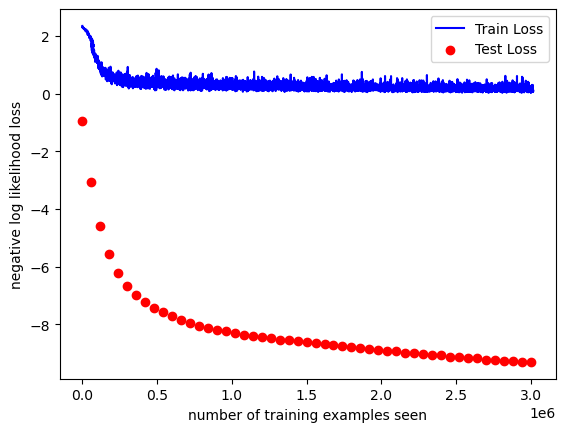

In [30]:
fig = plt.figure()
plt.plot(train_count, train_loss, color='blue')
plt.scatter(test_count, test_loss, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [31]:
# with torch.no_grad():
#   output = model(example_data)

# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Prediction: {}".format(
#     output.data.max(1, keepdim=True)[1][i].item()))
#   plt.xticks([])
#   plt.yticks([])